# Yachay.ai Task

## Overview

This project takes on the goal to improve upon Yachay.ai's infrastructure to train a deep learning model to predict coordinates of individual texts.

The first suggested methodology on training the model is to look into the annotated data set on texts posted from across North America. The goal is to identify the location of the user: be that by predicting an exact geopoint, or make a broader, region-based estimate (for example: one student’s model returns exact coordinates of the building, while another student trains a classification model to predict a city rather than the exact geopoint).

## Data Description

The main dataset consists of tweet information, with each row containing the following user data:

- 'text': The content of the tweet.
-  id': The unique ID of the tweet.
- 'user_id': The ID of the user who posted the tweet.
- 'timestamp': The date and time when the tweet was posted.
- 'cluster_id': The assigned ID related to the area from which the tweet was posted.

Cluster coordinates dataset contains the cluster id as well as the latitutde and longitude data.
- 'cluster_id': The assigned ID related to the area from which the tweet was posted.
- 'lat': The latitude of the tweet.
- 'lng': The longitude of the tweet.

In [6]:
!pip install geopandas
!pip install langid
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 96.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.9 MB/s eta 0:00:00


In [1]:
# import libraries
import pandas as pd
import plotly.express as px
import numpy as np
import re
import geopandas as gpd

# import machine learning module from the sklearn library
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import make_column_transformer
import seaborn as sns
from sklearn.cluster import KMeans

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, concatenate
from keras.optimizers import Adam
import tensorflow as tf

# statistical visualization
import matplotlib.pyplot as plt
from numpy import genfromtxt

#from wordcloud import WordCloud
import folium
from folium.plugins import HeatMap
from shapely.geometry import Point

import langid
from langid import classify

import torch
import transformers
from tqdm.auto import tqdm
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import math
from sklearn.metrics.pairwise import haversine_distances
from math import radians
#from transformers import XLMRobertaTokenizerFast
import joblib
from math import ceil

#import packages
from PIL import Image
from statistics import mode


In [2]:
# Set up some parameters for building plots

plt.style.use("seaborn-v0_8")
sns.set_style("dark", {"axes.facecolor": ".95"})
sns.set_palette("cubehelix")

plt.rcParams["figure.figsize"] = (9, 4)
%config InlineBackend.figure_format = "retina"
%matplotlib inline

In [ ]:
# function to determine if columns in file have null values
def get_percent_of_na(df, num):
    count = 0
    df = df.copy()
    s = (df.isna().sum() / df.shape[0])
    for column, percent in zip(s.index, s.values):
        num_of_nulls = df[column].isna().sum()
        if num_of_nulls == 0:
            continue
        else:
            count += 1
        print('Column {} has {:.{}%} percent of Nulls, and {} of nulls'.format(column, percent, num, num_of_nulls))
    if count != 0:
        print("\033[1m" + 'There are {} columns with NA.'.format(count) + "\033[0m")
    else:
        print()
        print("\033[1m" + 'There are no columns with NA.' + "\033[0m")

# function to display general information about the dataset
def get_info(df):
    """
    This function uses the head(), info(), describe(), shape() and duplicated()
    methods to display the general information about the dataset.
    """
    print("\033[1m" + '-'*100 + "\033[0m")
    print('Head:')
    print()
    display(df.head())
    print('-'*100)
    print('Info:')
    print()
    display(df.info())
    print('-'*100)
    print()
    print('Data with Missing Index:',df.index.isna().sum())

    print('-'*100)
    print()
    # percentage of data with missing index
    print('Percentage of data with missing index:',df.index.isna().sum() / len(df_main) * 100)
    print()
    display(get_percent_of_na(df, 4))  # check this out
    print('-'*100)
    print('Shape:')
    print(df.shape)
    print('-'*100)
    print('Duplicated:')
    print("\033[1m" + 'We have {} duplicated rows.\n'.format(df.duplicated().sum()) + "\033[0m")

## Data Preprocessing

### Main Dataset

In [ ]:
# read dataset

df_main = pd.read_csv('/Users/gguillau/Desktop/Career/Practicum/Externships/Yachay.ai/data/Main_Dataset.csv', parse_dates=['timestamp'], index_col=['timestamp'])




In [ ]:
# sort by timestamp

df_main.sort_index(inplace=True)


In [ ]:
# study the general information about the internet dataset

get_info(df_main)

----------------------------------------------------------------------------------------------------
Head:



,id,text,user_id,cluster_id
timestamp,,,,
2021-02-01 12:14:04,262304,he was accused of being a thief when entering ...,8.301517e+08,345
2021-02-01 12:19:19,480231,can you blame him they are delicious,1.817364e+08,1775
2021-02-01 12:21:52,241532,damn sholl is a new month ain’t it,2.383825e+08,288
2021-02-01 12:28:10,324986,ain’t felt this way inna min,4.598618e+08,603
2021-02-01 12:35:05,541682,golf central is practically unwatchable this m...,4.041955e+09,2318


----------------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 604206 entries, 2021-02-01 12:14:04 to NaT
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          604206 non-null  int64  
 1   text        604206 non-null  object 
 2   user_id     604206 non-null  float64
 3   cluster_id  604206 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 23.0+ MB


None

----------------------------------------------------------------------------------------------------

Data with Missing Index: 12794
----------------------------------------------------------------------------------------------------

Percentage of data with missing index: 2.1174897303237636


There are no columns with NA.


None

----------------------------------------------------------------------------------------------------
Shape:
(604206, 4)
----------------------------------------------------------------------------------------------------
Duplicated:
We have 0 duplicated rows.



### Cluster Coordinates

In [ ]:
# load cluster data

df_cl = pd.read_csv('/Users/gguillau/Desktop/Career/Practicum/Externships/Yachay.ai/data/Clusters_Coordinates.csv')

In [ ]:
get_info(df_cl)

----------------------------------------------------------------------------------------------------
Head:



,cluster_id,lat,lng
0,2,34.020789,-118.411907
1,3,31.168893,-100.076888
2,8,29.838495,-95.446487
3,9,40.780709,-73.968542
4,16,40.004866,-75.117998


----------------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   cluster_id  850 non-null    int64  
 1   lat         850 non-null    float64
 2   lng         850 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 20.0 KB


None

----------------------------------------------------------------------------------------------------

Data with Missing Index: 0
----------------------------------------------------------------------------------------------------

Percentage of data with missing index: 0.0


There are no columns with NA.


None

----------------------------------------------------------------------------------------------------
Shape:
(850, 3)
----------------------------------------------------------------------------------------------------
Duplicated:
We have 0 duplicated rows.



### Conclusion

Overall, the main dataset is fairly clean. We loaded the data as a timeseries, and parsed the dates. This dataframe contains most of the features we need to train a our model. The data that is missing is limited to timestamps, while the other columns of this data is present. As the missing data represents 2% of the entire dataset, and becase we are unable to impute the timestamps, we will drop these rows.


Cluster coordinates dataframe contains the cluster id as well as the latitutde and longitude data. This dataframe is clean with no missing values. We will merge the two dataframes before conducting EDA.



## Feature Engineering

In [ ]:
# visual of data before feature engineering
df_main.head()

,id,text,user_id,cluster_id
timestamp,,,,
2021-02-01 12:14:04,262304,he was accused of being a thief when entering ...,8.301517e+08,345
2021-02-01 12:19:19,480231,can you blame him they are delicious,1.817364e+08,1775
2021-02-01 12:21:52,241532,damn sholl is a new month ain’t it,2.383825e+08,288
2021-02-01 12:28:10,324986,ain’t felt this way inna min,4.598618e+08,603
2021-02-01 12:35:05,541682,golf central is practically unwatchable this m...,4.041955e+09,2318


In [ ]:
# # Making timestamp features
# #def make_features(data):
# #    data['year'] = data.index.year
# #    data['month'] = data.index.month
#     data['week'] = data.index.isocalendar().week
#     data['day'] = data.index.day
#     #data['day_of_week'] = data.index.day_of_week
#     data['day_of_week'] = data['timestamp'].dt.dayofweek

#     data['day_of_year'] = data.index.day_of_year
#     data['hour'] = data.index.hour
#     data['minute'] = data.index.minute
#     data['second'] = data.index.second

# make_features(df_main)

In [ ]:
# new features added
df_main.head()
df_main.reset_index(inplace=True)

In [ ]:
data = pd.merge(df_main, df_cl, on="cluster_id", how='left')
data

,timestamp,id,text,user_id,cluster_id,lat,lng
0,2021-02-01 12:14:04,262304,he was accused of being a thief when entering ...,8.301517e+08,345,36.786042,-119.782465
1,2021-02-01 12:19:19,480231,can you blame him they are delicious,1.817364e+08,1775,42.110703,-80.087032
2,2021-02-01 12:21:52,241532,damn sholl is a new month ain’t it,2.383825e+08,288,34.751936,-92.131274
3,2021-02-01 12:28:10,324986,ain’t felt this way inna min,4.598618e+08,603,31.079307,-97.753840
4,2021-02-01 12:35:05,541682,golf central is practically unwatchable this m...,4.041955e+09,2318,32.848817,-83.654079
...,...,...,...,...,...,...,...
604201,NaT,590366,just under 1100 hospitalization and under 400 ...,1.237179e+09,2837,43.748101,-78.948209
604202,NaT,590370,this is the norm in the south and 3rd world co...,3.601354e+08,2837,43.748101,-78.948209
604203,NaT,590372,yes in toronto they have mris scheduled day ni...,7.366558e+17,2837,43.748101,-78.948209
604204,NaT,590373,why i get this email from city md,3.601354e+08,2837,43.748101,-78.948209


### Sample

With limited resources, we can not work with the entire dataset of half a million rows. Our approach is to take a manageable sample of the data to work with. We will save that dataset, to reduce computation times.

Need to get a random sample of dataframe before tokenization, to ensure we get a much closer representation of the distribution of coordinates. current coordinates of non-random dataset is Los Angeles, CA.

In [ ]:
data_sample = data.sample(n=10000,random_state=12345)

In [ ]:
get_info(data_sample)

----------------------------------------------------------------------------------------------------
Head:



,timestamp,id,text,user_id,cluster_id,lat,lng
112700,2021-02-25 23:53:55,602607,you finna cook gimme,243888581.0,2984,13.909028,-60.976355
83611,2021-02-21 00:48:14,350342,it’s been a stressful week. day drinking it is.,40477835.0,797,37.973327,-121.998644
135480,2021-08-02 03:28:41,508262,jajja no puede ser dios que es esto,181226587.0,2010,24.662489,-107.342056
318197,2021-08-13 17:30:30,552138,ha good call out erica. i thought ole girl was...,455265512.0,2417,34.580925,-87.010551
264684,2021-08-10 11:59:51,179612,si je peux te faire une suggestion une proche ...,120534577.0,160,45.557831,-73.723025


----------------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 112700 to 181333
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   timestamp   9787 non-null   datetime64[ns]
 1   id          10000 non-null  int64         
 2   text        10000 non-null  object        
 3   user_id     10000 non-null  float64       
 4   cluster_id  10000 non-null  int64         
 5   lat         10000 non-null  float64       
 6   lng         10000 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 625.0+ KB


None

----------------------------------------------------------------------------------------------------

Data with Missing Index: 0
----------------------------------------------------------------------------------------------------

Percentage of data with missing index: 0.0

Column timestamp has 2.1300% percent of Nulls, and 213 of nulls
There are 1 columns with NA.


None

----------------------------------------------------------------------------------------------------
Shape:
(10000, 7)
----------------------------------------------------------------------------------------------------
Duplicated:
We have 0 duplicated rows.



In [ ]:
# drop missing values
data_sample.dropna(inplace=True)
data_sample.isna().sum()

timestamp     0
id            0
text          0
user_id       0
cluster_id    0
lat           0
lng           0
dtype: int64

In [ ]:
# convert 'timestamp' column to datetime format
data_sample['timestamp'] = pd.to_datetime(data['timestamp'])

# add columns with year, month, day, day of week, time and time of day
data_sample['year'] = data_sample['timestamp'].dt.year
data_sample['month'] = data_sample['timestamp'].dt.month
data_sample['day_of_month'] = data_sample['timestamp'].dt.day
data_sample['day'] = data_sample['timestamp'].dt.dayofweek
data_sample['time'] = data_sample['timestamp'].dt.time
data_sample['time_of_the_day'] = pd.cut(data_sample['timestamp'].dt.hour, bins=[0, 6, 12, 18, 24], include_lowest=True, labels=['night', 'morning', 'afternoon', 'evening'])

#  Dictionary of days of the week
days_dict = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

# function to convert day of the week numbers
def get_weekday(day):
    return days_dict[day]

data_sample['weekday'] = data_sample['day'].apply(get_weekday)

# remove original day column
data_sample.drop(columns=['day'], inplace=True)

In [ ]:
data_sample

,timestamp,id,text,user_id,cluster_id,lat,lng,year,month,day_of_month,time,time_of_the_day,weekday
112700,2021-02-25 23:53:55,602607,you finna cook gimme,2.438886e+08,2984,13.909028,-60.976355,2021,2,25,23:53:55,evening,Thursday
83611,2021-02-21 00:48:14,350342,it’s been a stressful week. day drinking it is.,4.047784e+07,797,37.973327,-121.998644,2021,2,21,00:48:14,night,Sunday
135480,2021-08-02 03:28:41,508262,jajja no puede ser dios que es esto,1.812266e+08,2010,24.662489,-107.342056,2021,8,2,03:28:41,night,Monday
318197,2021-08-13 17:30:30,552138,ha good call out erica. i thought ole girl was...,4.552655e+08,2417,34.580925,-87.010551,2021,8,13,17:30:30,afternoon,Friday
264684,2021-08-10 11:59:51,179612,si je peux te faire une suggestion une proche ...,1.205346e+08,160,45.557831,-73.723025,2021,8,10,11:59:51,morning,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
141462,2021-08-02 16:33:14,552191,jurors just left for lunch. not sure how long ...,1.383190e+18,2417,34.580925,-87.010551,2021,8,2,16:33:14,afternoon,Monday
176296,2021-08-04 16:38:40,308196,fellas it’s that simple,1.732422e+08,517,36.006256,-115.038337,2021,8,4,16:38:40,afternoon,Wednesday
378786,2021-08-17 17:12:52,185798,every word counts . our fearless national hero...,3.229770e+07,165,18.115407,-77.275953,2021,8,17,17:12:52,afternoon,Tuesday
137099,2021-08-02 05:57:57,405182,republicans don’t give a rat’s ass or any coun...,1.654224e+09,1224,32.964484,-96.690937,2021,8,2,05:57:57,night,Monday


### Tweet Location

In [ ]:

# download state borders
usa = gpd.read_file('/Users/gguillau/Desktop/Career/Practicum/Externships/Yachay.ai/data/tl_2017_us_state/tl_2017_us_state.shp')

# create a function that determines whether the coordinates belong to the state:
def get_state(lat, lng):
    point = Point(lng, lat)
    for idx, row in usa.iterrows():
        if row.geometry.contains(point):
            return row['STUSPS']
    return 'Unknown'

data_sample['state'] = data_sample.apply(lambda row: get_state(row['lat'], row['lng']), axis=1)

data_sample.to_csv('Dataset_with_state.csv', index=False)
data_sample

,timestamp,id,text,user_id,cluster_id,lat,lng,year,month,day_of_month,time,time_of_the_day,weekday,state
112700,2021-02-25 23:53:55,602607,you finna cook gimme,2.438886e+08,2984,13.909028,-60.976355,2021,2,25,23:53:55,evening,Thursday,Unknown
83611,2021-02-21 00:48:14,350342,it’s been a stressful week. day drinking it is.,4.047784e+07,797,37.973327,-121.998644,2021,2,21,00:48:14,night,Sunday,CA
135480,2021-08-02 03:28:41,508262,jajja no puede ser dios que es esto,1.812266e+08,2010,24.662489,-107.342056,2021,8,2,03:28:41,night,Monday,Unknown
318197,2021-08-13 17:30:30,552138,ha good call out erica. i thought ole girl was...,4.552655e+08,2417,34.580925,-87.010551,2021,8,13,17:30:30,afternoon,Friday,AL
264684,2021-08-10 11:59:51,179612,si je peux te faire une suggestion une proche ...,1.205346e+08,160,45.557831,-73.723025,2021,8,10,11:59:51,morning,Tuesday,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141462,2021-08-02 16:33:14,552191,jurors just left for lunch. not sure how long ...,1.383190e+18,2417,34.580925,-87.010551,2021,8,2,16:33:14,afternoon,Monday,AL
176296,2021-08-04 16:38:40,308196,fellas it’s that simple,1.732422e+08,517,36.006256,-115.038337,2021,8,4,16:38:40,afternoon,Wednesday,NV
378786,2021-08-17 17:12:52,185798,every word counts . our fearless national hero...,3.229770e+07,165,18.115407,-77.275953,2021,8,17,17:12:52,afternoon,Tuesday,Unknown
137099,2021-08-02 05:57:57,405182,republicans don’t give a rat’s ass or any coun...,1.654224e+09,1224,32.964484,-96.690937,2021,8,2,05:57:57,night,Monday,TX


In [ ]:
# download country borders
world = gpd.read_file('/Users/gguillau/Downloads/TM_WORLD_BORDERS_SIMPL-0.3/TM_WORLD_BORDERS_SIMPL-0.3.shp')
world

,FIPS,ISO2,ISO3,UN,NAME,AREA,POP2005,REGION,SUBREGION,LON,LAT,geometry
0,AC,AG,ATG,28,Antigua and Barbuda,44,83039,19,29,-61.783,17.078,"MULTIPOLYGON (((-61.68667 17.02444, -61.88722 ..."
1,AG,DZ,DZA,12,Algeria,238174,32854159,2,15,2.632,28.163,"POLYGON ((2.96361 36.80222, 4.78583 36.89472, ..."
2,AJ,AZ,AZE,31,Azerbaijan,8260,8352021,142,145,47.395,40.430,"MULTIPOLYGON (((45.08332 39.76805, 45.81999 39..."
3,AL,AL,ALB,8,Albania,2740,3153731,150,39,20.068,41.143,"POLYGON ((19.43621 41.02107, 19.60056 41.79666..."
4,AM,AM,ARM,51,Armenia,2820,3017661,142,145,44.563,40.534,"POLYGON ((45.15387 41.19860, 46.00194 40.22555..."
...,...,...,...,...,...,...,...,...,...,...,...,...
241,TB,BL,BLM,652,Saint Barthelemy,0,0,19,29,-63.043,18.040,"POLYGON ((-63.02834 18.01555, -63.13984 18.058..."
242,GK,GG,GGY,831,Guernsey,0,0,150,154,-2.576,49.459,"POLYGON ((-2.59083 49.42249, -2.67028 49.43417..."
243,JE,JE,JEY,832,Jersey,0,0,150,154,-2.129,49.219,"POLYGON ((-2.01500 49.21416, -2.20528 49.18083..."
244,SX,GS,SGS,239,South Georgia South Sandwich Islands,0,0,0,0,-36.891,-54.209,"MULTIPOLYGON (((-27.32584 -59.42722, -27.29806..."


In [ ]:
data_sample

,timestamp,id,text,user_id,cluster_id,lat,lng,year,month,day_of_month,time,time_of_the_day,weekday,state
112700,2021-02-25 23:53:55,602607,you finna cook gimme,2.438886e+08,2984,13.909028,-60.976355,2021,2,25,23:53:55,evening,Thursday,Unknown
83611,2021-02-21 00:48:14,350342,it’s been a stressful week. day drinking it is.,4.047784e+07,797,37.973327,-121.998644,2021,2,21,00:48:14,night,Sunday,CA
135480,2021-08-02 03:28:41,508262,jajja no puede ser dios que es esto,1.812266e+08,2010,24.662489,-107.342056,2021,8,2,03:28:41,night,Monday,Unknown
318197,2021-08-13 17:30:30,552138,ha good call out erica. i thought ole girl was...,4.552655e+08,2417,34.580925,-87.010551,2021,8,13,17:30:30,afternoon,Friday,AL
264684,2021-08-10 11:59:51,179612,si je peux te faire une suggestion une proche ...,1.205346e+08,160,45.557831,-73.723025,2021,8,10,11:59:51,morning,Tuesday,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141462,2021-08-02 16:33:14,552191,jurors just left for lunch. not sure how long ...,1.383190e+18,2417,34.580925,-87.010551,2021,8,2,16:33:14,afternoon,Monday,AL
176296,2021-08-04 16:38:40,308196,fellas it’s that simple,1.732422e+08,517,36.006256,-115.038337,2021,8,4,16:38:40,afternoon,Wednesday,NV
378786,2021-08-17 17:12:52,185798,every word counts . our fearless national hero...,3.229770e+07,165,18.115407,-77.275953,2021,8,17,17:12:52,afternoon,Tuesday,Unknown
137099,2021-08-02 05:57:57,405182,republicans don’t give a rat’s ass or any coun...,1.654224e+09,1224,32.964484,-96.690937,2021,8,2,05:57:57,night,Monday,TX


In [ ]:

# create a function that determines whether the coordinates belong to the country:
def get_country(lat, lng):
    point = Point(lng, lat)
    for idx, row in world.iterrows():
        if row.geometry.contains(point):
            return row['NAME']
    return 'Unknown'

data_sample['country'] = data_sample.apply(lambda row: get_country(row['lat'], row['lng']), axis=1)

data_sample.to_csv('Dataset_with_country.csv', index=False)
data_sample

,timestamp,id,text,user_id,cluster_id,lat,lng,year,month,day_of_month,time,time_of_the_day,weekday,state,country
112700,2021-02-25 23:53:55,602607,you finna cook gimme,2.438886e+08,2984,13.909028,-60.976355,2021,2,25,23:53:55,evening,Thursday,Unknown,Saint Lucia
83611,2021-02-21 00:48:14,350342,it’s been a stressful week. day drinking it is.,4.047784e+07,797,37.973327,-121.998644,2021,2,21,00:48:14,night,Sunday,CA,United States
135480,2021-08-02 03:28:41,508262,jajja no puede ser dios que es esto,1.812266e+08,2010,24.662489,-107.342056,2021,8,2,03:28:41,night,Monday,Unknown,Mexico
318197,2021-08-13 17:30:30,552138,ha good call out erica. i thought ole girl was...,4.552655e+08,2417,34.580925,-87.010551,2021,8,13,17:30:30,afternoon,Friday,AL,United States
264684,2021-08-10 11:59:51,179612,si je peux te faire une suggestion une proche ...,1.205346e+08,160,45.557831,-73.723025,2021,8,10,11:59:51,morning,Tuesday,Unknown,Canada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141462,2021-08-02 16:33:14,552191,jurors just left for lunch. not sure how long ...,1.383190e+18,2417,34.580925,-87.010551,2021,8,2,16:33:14,afternoon,Monday,AL,United States
176296,2021-08-04 16:38:40,308196,fellas it’s that simple,1.732422e+08,517,36.006256,-115.038337,2021,8,4,16:38:40,afternoon,Wednesday,NV,United States
378786,2021-08-17 17:12:52,185798,every word counts . our fearless national hero...,3.229770e+07,165,18.115407,-77.275953,2021,8,17,17:12:52,afternoon,Tuesday,Unknown,Jamaica
137099,2021-08-02 05:57:57,405182,republicans don’t give a rat’s ass or any coun...,1.654224e+09,1224,32.964484,-96.690937,2021,8,2,05:57:57,night,Monday,TX,United States


### Tweet Langauge

In [ ]:
data_sample.to_csv('Dataset_with_state.csv', index=False)
# create a new column with the language of each row

data_sample['language'] = data_sample['text'].apply(lambda x: langid.classify(x)[0])

data_sample.head(15)
data_sample.to_csv('Dataset_with_state_language.csv', index=False)

#data_location_language = pd.read_csv('Dataset_with_state_langauge.csv')


In [ ]:
data_sample

,timestamp,id,text,user_id,cluster_id,lat,lng,year,month,day_of_month,time,time_of_the_day,weekday,state,country,language
112700,2021-02-25 23:53:55,602607,you finna cook gimme,2.438886e+08,2984,13.909028,-60.976355,2021,2,25,23:53:55,evening,Thursday,Unknown,Saint Lucia,ga
83611,2021-02-21 00:48:14,350342,it’s been a stressful week. day drinking it is.,4.047784e+07,797,37.973327,-121.998644,2021,2,21,00:48:14,night,Sunday,CA,United States,en
135480,2021-08-02 03:28:41,508262,jajja no puede ser dios que es esto,1.812266e+08,2010,24.662489,-107.342056,2021,8,2,03:28:41,night,Monday,Unknown,Mexico,es
318197,2021-08-13 17:30:30,552138,ha good call out erica. i thought ole girl was...,4.552655e+08,2417,34.580925,-87.010551,2021,8,13,17:30:30,afternoon,Friday,AL,United States,en
264684,2021-08-10 11:59:51,179612,si je peux te faire une suggestion une proche ...,1.205346e+08,160,45.557831,-73.723025,2021,8,10,11:59:51,morning,Tuesday,Unknown,Canada,fr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141462,2021-08-02 16:33:14,552191,jurors just left for lunch. not sure how long ...,1.383190e+18,2417,34.580925,-87.010551,2021,8,2,16:33:14,afternoon,Monday,AL,United States,en
176296,2021-08-04 16:38:40,308196,fellas it’s that simple,1.732422e+08,517,36.006256,-115.038337,2021,8,4,16:38:40,afternoon,Wednesday,NV,United States,en
378786,2021-08-17 17:12:52,185798,every word counts . our fearless national hero...,3.229770e+07,165,18.115407,-77.275953,2021,8,17,17:12:52,afternoon,Tuesday,Unknown,Jamaica,en
137099,2021-08-02 05:57:57,405182,republicans don’t give a rat’s ass or any coun...,1.654224e+09,1224,32.964484,-96.690937,2021,8,2,05:57:57,night,Monday,TX,United States,en


In [ ]:
# convert 'timestamp' column to datetime format
data_sample['timestamp'] = pd.to_datetime(data['timestamp'])

# add columns with year, month, day, day of week, time and time of day
data_sample['year'] = data_sample['timestamp'].dt.year
data_sample['month'] = data_sample['timestamp'].dt.month
data_sample['day_of_month'] = data_sample['timestamp'].dt.day
data_sample['day'] = data_sample['timestamp'].dt.dayofweek
data_sample['time'] = data_sample['timestamp'].dt.time
data_sample['time_of_the_day'] = pd.cut(data_sample['timestamp'].dt.hour, bins=[0, 6, 12, 18, 24], include_lowest=True, labels=['night', 'morning', 'afternoon', 'evening'])


In [ ]:
# remove original timestamp column
data_sample.drop(columns=['timestamp'], inplace=True)

In [ ]:
get_info(data_sample)

----------------------------------------------------------------------------------------------------
Head:



,id,text,user_id,cluster_id,lat,lng,year,month,day_of_month,time,time_of_the_day,weekday,state,country,language,day
112700,602607,you finna cook gimme,243888581.0,2984,13.909028,-60.976355,2021,2,25,23:53:55,evening,Thursday,Unknown,Saint Lucia,ga,3
83611,350342,it’s been a stressful week. day drinking it is.,40477835.0,797,37.973327,-121.998644,2021,2,21,00:48:14,night,Sunday,CA,United States,en,6
135480,508262,jajja no puede ser dios que es esto,181226587.0,2010,24.662489,-107.342056,2021,8,2,03:28:41,night,Monday,Unknown,Mexico,es,0
318197,552138,ha good call out erica. i thought ole girl was...,455265512.0,2417,34.580925,-87.010551,2021,8,13,17:30:30,afternoon,Friday,AL,United States,en,4
264684,179612,si je peux te faire une suggestion une proche ...,120534577.0,160,45.557831,-73.723025,2021,8,10,11:59:51,morning,Tuesday,Unknown,Canada,fr,1


----------------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9787 entries, 112700 to 181333
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   id               9787 non-null   int64   
 1   text             9787 non-null   object  
 2   user_id          9787 non-null   float64 
 3   cluster_id       9787 non-null   int64   
 4   lat              9787 non-null   float64 
 5   lng              9787 non-null   float64 
 6   year             9787 non-null   int64   
 7   month            9787 non-null   int64   
 8   day_of_month     9787 non-null   int64   
 9   time             9787 non-null   object  
 10  time_of_the_day  9787 non-null   category
 11  weekday          9787 non-null   object  
 12  state            9787 non-null   object  
 13  country          9787 non-null   object  
 14  language         9787

None

----------------------------------------------------------------------------------------------------

Data with Missing Index: 0
----------------------------------------------------------------------------------------------------

Percentage of data with missing index: 0.0


There are no columns with NA.


None

----------------------------------------------------------------------------------------------------
Shape:
(9787, 16)
----------------------------------------------------------------------------------------------------
Duplicated:
We have 0 duplicated rows.



In [ ]:
# drop missing values
data_sample.dropna(inplace=True)

# missing values
data_sample.isna().sum()

id                 0
text               0
user_id            0
cluster_id         0
lat                0
lng                0
year               0
month              0
day_of_month       0
time               0
time_of_the_day    0
weekday            0
state              0
country            0
language           0
day                0
dtype: int64

In [ ]:
data_sample.to_csv('data_sample.csv', index=False)


### Conclusion

We merged the datasets on cluster id. We then dropped all rows with the missing timestamp data. We are left with a total of close to 600,000 rows of data.

Additional features were incorporated into the model, including:

- 'state': The state tweet was posted from.
- 'country': The country tweet was posted from.
- 'language': The language of the tweet.
- 'day': The day the tweet was posted.
- 'weekday': The day of the week tweet was posted.
- 'time_of_day': The time of day tweet was posted.
- 'month': The month the tweet was posted.

## Exploratory Data Analysis

In [ ]:
# summary statistics
data_sample.describe()

,id,user_id,cluster_id,lat,lng,year,month,day_of_month,day
count,9787.000000,9.787000e+03,9787.000000,9787.000000,9787.000000,9787.0,9787.000000,9787.000000,9787.000000
mean,302249.451722,3.365344e+17,879.470113,34.302307,-92.989523,2021.0,6.763360,15.494227,2.912128
std,173588.977920,5.238827e+17,891.094622,7.600021,15.984153,0.0,2.435347,8.443283,2.027363
min,6.000000,1.022900e+04,2.000000,13.189300,-158.069430,2021.0,2.000000,1.000000,0.000000
25%,153651.500000,1.406234e+08,110.000000,30.086918,-100.270474,2021.0,8.000000,8.000000,1.000000
50%,302503.000000,8.081014e+08,493.000000,34.087010,-91.090800,2021.0,8.000000,16.000000,3.000000
75%,450874.000000,8.504131e+17,1541.500000,40.568911,-80.084212,2021.0,8.000000,23.000000,5.000000
max,604192.000000,1.428968e+18,2996.000000,61.235042,-52.829425,2021.0,9.000000,31.000000,6.000000


In [ ]:
px.imshow(data_sample.corr(), text_auto=True, aspect='auto',color_continuous_scale='bluyl')


/var/folders/dz/qvhlrw991895182jmrfwcl1m0000gn/T/ipykernel_2756/4262987347.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  px.imshow(data_sample.corr(), text_auto=True, aspect='auto',color_continuous_scale='bluyl')


In [ ]:
data_sample

,id,text,user_id,cluster_id,lat,lng,year,month,day_of_month,time,time_of_the_day,weekday,state,country,language,day
112700,602607,you finna cook gimme,2.438886e+08,2984,13.909028,-60.976355,2021,2,25,23:53:55,evening,Thursday,Unknown,Saint Lucia,ga,3
83611,350342,it’s been a stressful week. day drinking it is.,4.047784e+07,797,37.973327,-121.998644,2021,2,21,00:48:14,night,Sunday,CA,United States,en,6
135480,508262,jajja no puede ser dios que es esto,1.812266e+08,2010,24.662489,-107.342056,2021,8,2,03:28:41,night,Monday,Unknown,Mexico,es,0
318197,552138,ha good call out erica. i thought ole girl was...,4.552655e+08,2417,34.580925,-87.010551,2021,8,13,17:30:30,afternoon,Friday,AL,United States,en,4
264684,179612,si je peux te faire une suggestion une proche ...,1.205346e+08,160,45.557831,-73.723025,2021,8,10,11:59:51,morning,Tuesday,Unknown,Canada,fr,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141462,552191,jurors just left for lunch. not sure how long ...,1.383190e+18,2417,34.580925,-87.010551,2021,8,2,16:33:14,afternoon,Monday,AL,United States,en,0
176296,308196,fellas it’s that simple,1.732422e+08,517,36.006256,-115.038337,2021,8,4,16:38:40,afternoon,Wednesday,NV,United States,en,2
378786,185798,every word counts . our fearless national hero...,3.229770e+07,165,18.115407,-77.275953,2021,8,17,17:12:52,afternoon,Tuesday,Unknown,Jamaica,en,1
137099,405182,republicans don’t give a rat’s ass or any coun...,1.654224e+09,1224,32.964484,-96.690937,2021,8,2,05:57:57,night,Monday,TX,United States,en,0


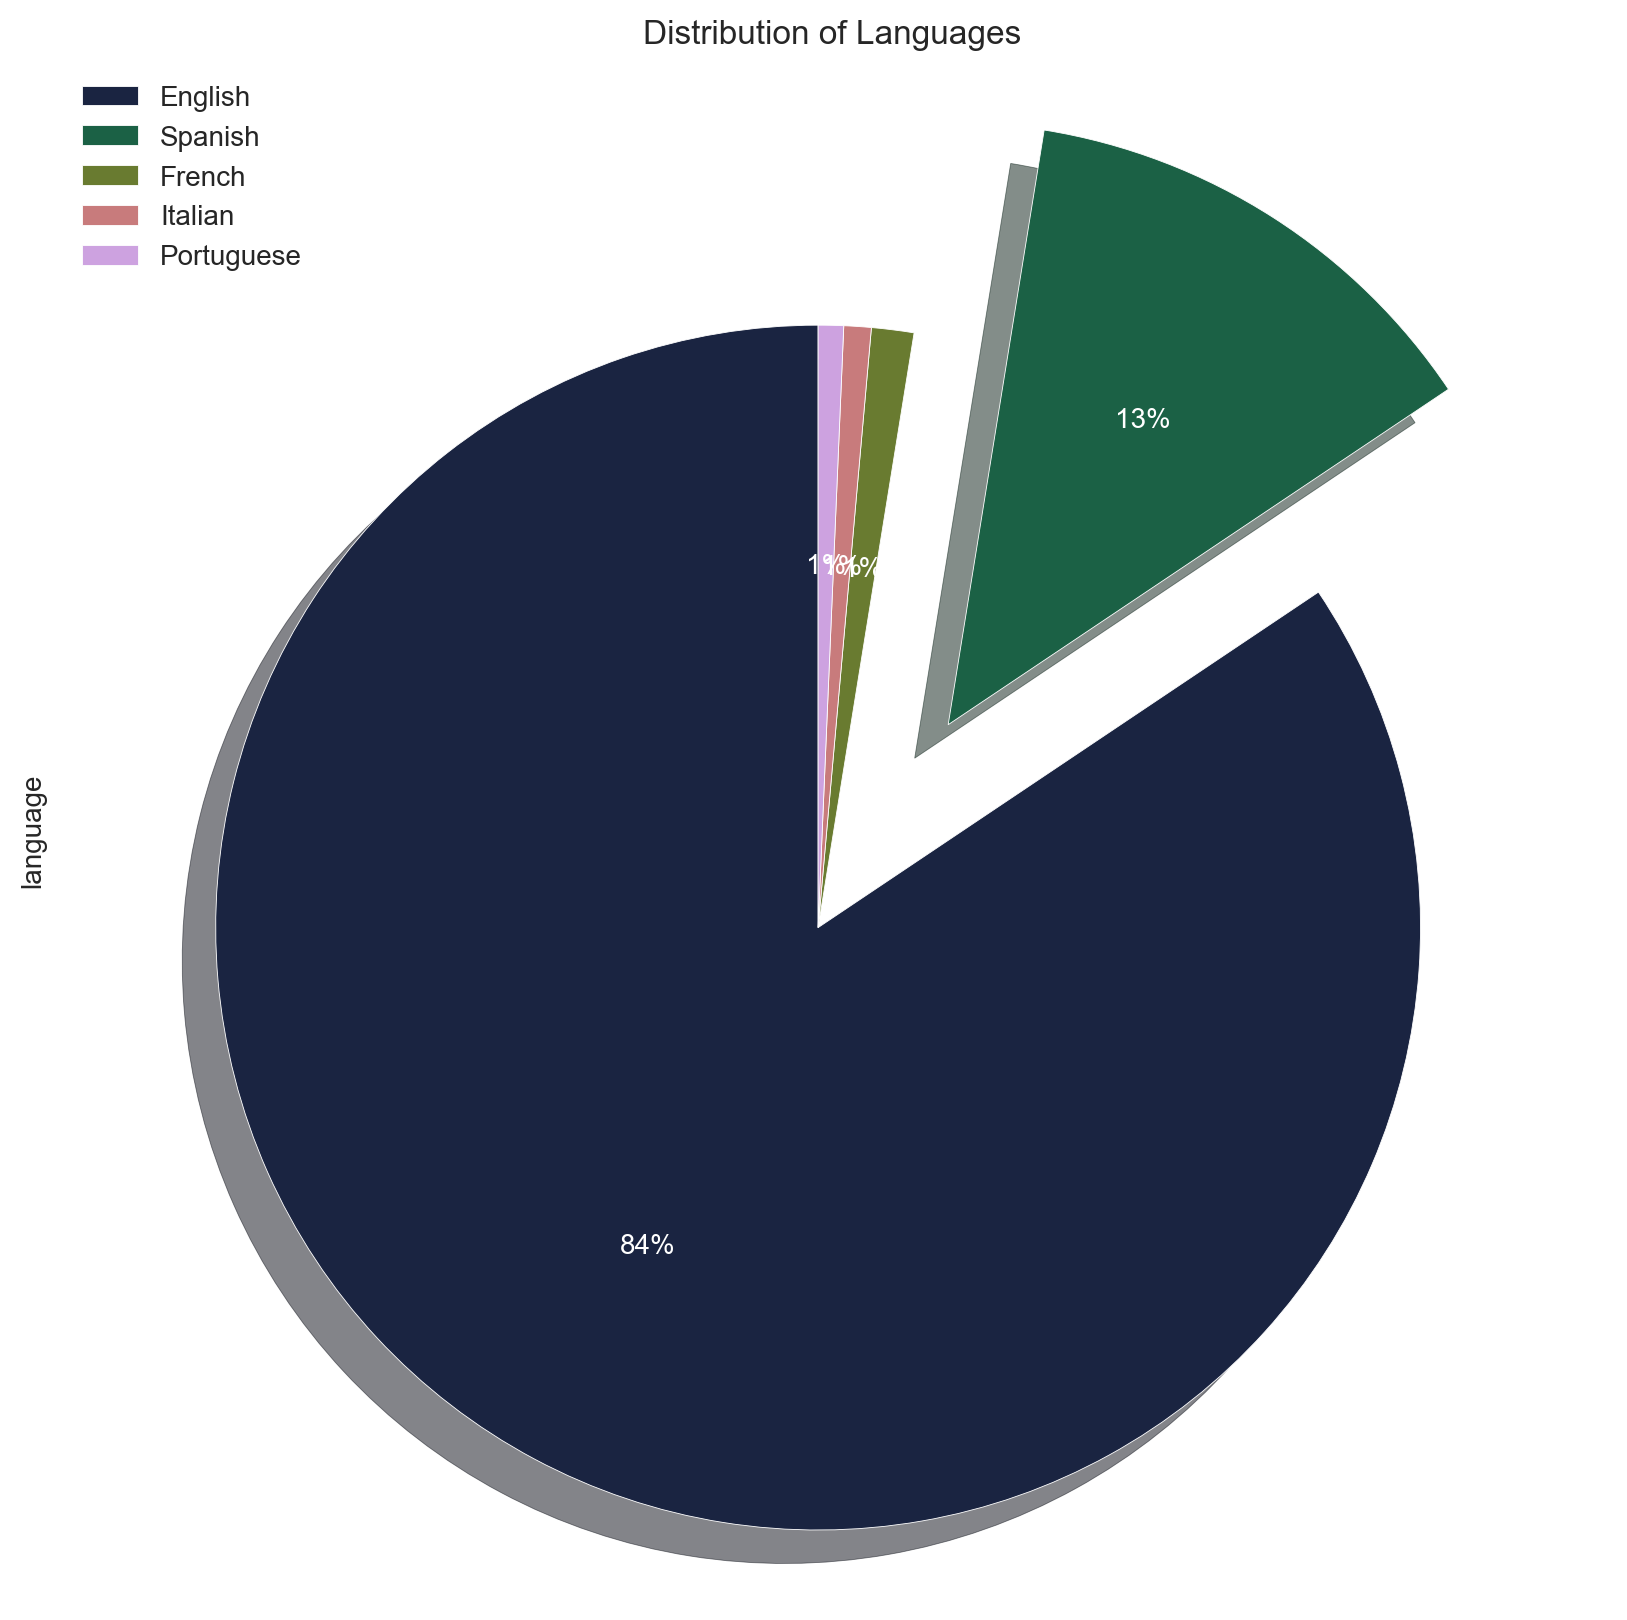

In [ ]:
lang_dist = data_sample['language'].value_counts().head()
explode = [0, 0.4, 0,0,0]
lang_dist.plot(kind='pie', autopct='%1.0f%%', startangle=90, figsize=(10,10), shadow=True, explode=explode,textprops={'color':"w"})
labels = ['English', 'Spanish', 'French', 'Italian','Portuguese']
plt.title('Distribution of Languages')
plt.axis('equal')  # This ensures that the pie is drawn as a circle.
plt.legend(labels=labels, loc="best")
plt.savefig('languagepie.png')
plt.show()

In [ ]:
# distributions of columns
columns = ['month', 'day_of_month', 'weekday',  'time_of_the_day','state','country','language']
for column in columns:
    px.histogram(data_sample[column],   color_discrete_sequence=['mediumpurple'], title='Distribution of Tweets by '+ str.upper(column).replace('_', ' '), labels={'value': str(column).replace('_', ' ')}).show()


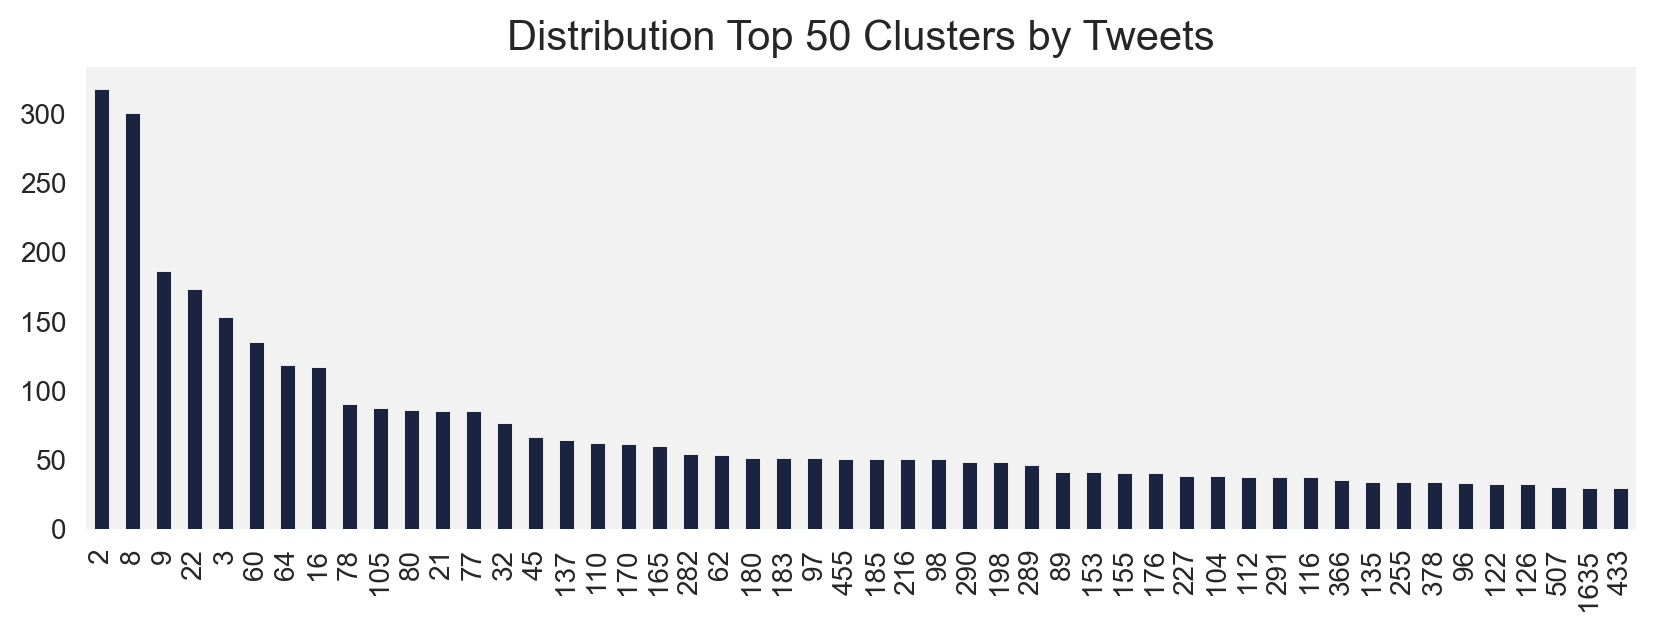

In [ ]:
data_sample['cluster_id'].value_counts().head(50).sort_values(ascending = False).plot.bar(figsize=(10,3 ))
plt.title("Distribution Top 50 Clusters by Tweets", size=15)
plt.show()

In [ ]:
data_sample['state'].nunique()

data_sample['state'].unique()

m = folium.Map(location=[data_sample['lat'].mean(), data_sample['lng'].mean()], zoom_start=10)

# Creating a heat map layer based on coordinates
heat_data = [[row['lat'],row['lng']] for index, row in data_sample.iterrows()]
HeatMap(heat_data).add_to(m)

# display the map
m

In [ ]:
# Group the Members Referred by country
data_state = data_sample.groupby(["state"]).agg({"id": "count"}).reset_index()

# Draw a heat map of the Members Referred by US state
print('The distribution of states by the number of members on the map.')
fig = px.choropleth(data_state,
                    locations='state',
                    locationmode="USA-states",
                    scope="usa",
                    color='id',
                    color_continuous_scale="mint",

                    )
fig.show()

The distribution of states by the number of members on the map.


### Conclusion
We see that the data is distributed towards two months out of the year: near the beginning and more near the end. We can see this trend in the monthly and year of the week timeframes. Along the daily timeframe, the data is uniformly distributed up until the last week of the month, at which point it declines to roughly half the mean of the month. The day of the week is distributed normally, so there are no differences seen during the week versus the weekned. The distribution in the time of day is mostly uniform, except for the gradual decline in the middle of the day immediately followed by the gradual increase back to uniform distribution. The lower timeframes of minutes and seconds are uniformly distributed.

User id and cluster id are right skewed.

The data is concentrated in North America, with most coordinates in the US and Mexico. We see most tweets appear in popular cities in the east coast and the west coast, with clusters in New York, California, and Florida. We see a few tweets originate from Alaska, Canada, Hawaii, and the Caribbean.

The heatmap further illustrates the distribution of tweets in the east coast of the US.

## Natural Langauge Process

The NLP tools we will be using are from Huggingface. We will test several different models to determine which one would work best with our dataset. We narrowed the options to BERT base, BERT multilingual, and XLM Roberta. Preprocessing will be similar among the three models, while the multilingual and XLM are optimized for english nd many other languages. We anticipate the multi language models to perform better than the base model, as our text data contains many different languages.



In [3]:
import re

def clean_text(text):
  text = re.sub(r"[^\w\s]", "", text)
  return text

In [4]:
def clear_text(text):
    pattern = r"[^a-zA-Z']"
    text = re.sub(pattern, ' ', text.lower())
    text = text.split()
    text = " ".join(text)
    return text

In [11]:
# map = folium.Map()

# for index, row in data_sample.iterrows():
#     lat, lng = row['lat'], row['lng']
#     folium.Marker([lat, lng]).add_to(map)

# from IPython.display import display
# display(map)

# #map.save('map_folim.html')


In [22]:
from google.colab import files
uploaded = files.upload()

KeyboardInterrupt: ignored

In [5]:

data_sample = pd.read_csv('data_sample.csv')

In [6]:
# looking through tweets
tweets = data_sample.text.tolist()
tweets[10:21]

['hell block party',
 'it was bad tho tv bill',
 "the teachers union is worse than aflcio back in hoffman's day much worse and more powerful",
 'queeeeee haceees hajahhahhahahahhahahhahahhahah éstos narradores mexicanos',
 'eminem’s verse on airplanes hit different as an adult',
 'are you trying to break up a good thing justsayin',
 "well i voted for cuomo long ago but lost interest in him after the first allegation by lyndsay b... she's a badass....",
 'stop ignoring the who amp cdc with regards to masks indoors. honestly what is wrong with you amp the mayor i don’t understand what science you’re following. the people of nyc can amp are capable of doing both. we deserve better than you both right now maskmandate getvaccinated',
 'flying spirit fuck it',
 'massage therapy is cheap.',
 'he doesn’t know that we find out today.']

In [7]:
# function to preprocess data for modelling
def preprocess_xlm(df, max_sample, batch_size=200):
    max_sample_size = max_sample # set the max sample size

    # preprocessing and XLM-RoBERTa
    tokenizer = transformers.XLMRobertaTokenizerFast.from_pretrained('xlm-roberta-large')

    ids_list_df = []
    attention_mask_list_df = []

    max_length = 512

    for input_text in df.iloc[:max_sample_size]['text']:
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list_df.append(padded)
        attention_mask_list_df.append(attention_mask)

    # get embeddings
    config = transformers.XLMRobertaConfig.from_pretrained('xlm-roberta-large')
    model = transformers.XLMRobertaModel.from_pretrained('xlm-roberta-large')

    batch_size = batch_size    # typically the batch size is equal to 100 but we can set it to lower values to lower the memory requirements

    embeddings_df = []

    device = torch.device('cuda') #if torch.cuda.is_available() else 'cpu')  # will use cpu unless cuda is available
    print(f'Using the {device} device.')
    model.to(device)

    for i in tqdm(range(len(ids_list_df) // batch_size)):

        ids_batch_df = torch.LongTensor(ids_list_df[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch_df = torch.LongTensor(attention_mask_list_df[batch_size*i:batch_size*(i+1)]).to(device)

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(ids_batch_df, attention_mask=attention_mask_batch_df)

        embeddings_df.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

    X = np.concatenate(embeddings_df)  # create features
    y = df.iloc[:max_sample_size][['lat', 'lng']] # create target with matching length as features

    print(X.shape)  # illustrate matching length
    print(y.shape)   # illustrate matching length

    np.savetxt("X_xlm_1000.csv", X, delimiter=",")
    y.to_csv('y_xlm_1000.csv', index=False)

    return X, y  # return the features and target dataframes

In [8]:
preprocess_xlm(data_sample,1000)

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using the cuda device.


  0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-7-a68d78492706>:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  ids_batch_df = torch.LongTensor(ids_list_df[batch_size*i:batch_size*(i+1)]).to(device)


(1000, 1024)
(1000, 2)


(array([[ 0.05388625,  0.06612524,  0.21406709, ...,  0.10224918,
          0.05316056, -0.02197684],
        [-0.01580774,  0.04706011,  0.25328746, ..., -0.13908744,
         -0.01459258, -0.05009694],
        [-0.01133773, -0.03291839,  0.10987335, ..., -0.01275121,
          0.12142009, -0.05097153],
        ...,
        [-0.00145062, -0.07498234,  0.14728537, ..., -0.09266208,
          0.03640577, -0.13625225],
        [-0.12171905,  0.05097913,  0.36734176, ..., -0.28058818,
          0.14165704, -0.24633461],
        [ 0.043756  ,  0.02199214,  0.15081684, ..., -0.15571031,
          0.03306897, -0.02091846]], dtype=float32),
            lat         lng
 0    13.909028  -60.976355
 1    37.973327 -121.998644
 2    24.662489 -107.342056
 3    34.580925  -87.010551
 4    45.557831  -73.723025
 ..         ...         ...
 995  32.482304  -84.917307
 996  32.017285  -81.109617
 997  43.430240  -80.476403
 998  39.170111  -77.264340
 999  49.853806  -97.152676
 
 [1000 rows x 2 colu

In [3]:
X_xlm = pd.read_csv('X_xlm_1000.csv', header=None)
# shape of embeddings
X_xlm.shape

(1000, 1024)

In [4]:
y_xlm = pd.read_csv('y_xlm_1000.csv')
# look at targets
y_xlm.head()
y_xlm.shape

(1000, 2)

In [5]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X_xlm, y_xlm, test_size=0.2, random_state=12345) # split 20% of data to make validation set

In [6]:
# haversine distance loss
RADIUS_KM = 6378.1

def degrees_to_radians(deg):
    pi_on_180 = 0.017453292519943295
    return deg * pi_on_180

def loss_haversine(observation, prediction):
    obv_rad = tf.map_fn(degrees_to_radians, observation)
    prev_rad = tf.map_fn(degrees_to_radians, prediction)

    dlon_dlat = obv_rad - prev_rad
    v = dlon_dlat / 2
    v = tf.sin(v)
    v = v**2

    a = v[:,1] + tf.cos(obv_rad[:,1]) * tf.cos(prev_rad[:,1]) * v[:,0]

    c = tf.sqrt(a)
    c = 2* tf.math.asin(c)
    c = c*RADIUS_KM
    final = tf.reduce_sum(c)

    #if you're interested in having MAE with the haversine distance in KM
    #uncomment the following line
    final = final/tf.dtypes.cast(tf.shape(observation)[0], dtype= tf.float32)

    return final

In [13]:
tf.random.set_seed(19)
optimizer = Adam(learning_rate=.0001)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=0.0000001)

# define the model architecture
model = Sequential()
model.add(Dense(8000, activation='relu', input_dim=(X_train.shape[1])))
model.add(Dense(4000, activation='relu'))
model.add(Dense(2000, activation='relu'))
model.add(Dense(1000, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(2)) # output layer with 2 units for latitude and longitude

# compile the model
model.compile(optimizer=optimizer, loss=loss_haversine, metrics=['mse'])

# train the model
with tf.device('/GPU:0'):
    history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.10, callbacks=[callback, reduce_lr], use_multiprocessing=True)


Epoch 1/5
23/23 [==============================] - 3s 57ms/step - loss: 4986.3804 - mse: 2020.5295 - val_loss: 2075.3689 - val_mse: 593.1032 - lr: 1.0000e-04
Epoch 2/5
23/23 [==============================] - 1s 42ms/step - loss: 1546.7002 - mse: 281.5229 - val_loss: 1632.2241 - val_mse: 214.0601 - lr: 1.0000e-04
Epoch 3/5
23/23 [==============================] - 1s 40ms/step - loss: 1442.7803 - mse: 177.8602 - val_loss: 1655.3607 - val_mse: 210.2516 - lr: 1.0000e-04
Epoch 4/5
23/23 [==============================] - 1s 40ms/step - loss: 1454.0398 - mse: 175.2516 - val_loss: 1672.8909 - val_mse: 218.5477 - lr: 1.0000e-04
Epoch 5/5
23/23 [==============================] - 1s 40ms/step - loss: 1410.5070 - mse: 162.8879 - val_loss: 1663.2656 - val_mse: 206.4376 - lr: 1.0000e-04


In [14]:
# evaluation on test set
model.evaluate(X_test, y_test)


7/7 [==============================] - 0s 16ms/step - loss: 1358.4695 - mse: 162.6799


[1358.469482421875, 162.67991638183594]

In [15]:
# X test predictions
preds = model.predict(X_test)

7/7 [==============================] - 0s 4ms/step


In [16]:
# chart of history metrics
import plotly.express as px
import pandas as pd

# Convert the model history to a pandas DataFrame
df_his = pd.DataFrame(history.history)

# Create separate figures for loss and accuracy
fig_loss = px.line(df_his, x=df_his.index, y=['loss', 'val_loss'], labels={'value': 'Loss', 'index': 'Epoch'}, title='Model Loss')
fig_acc = px.line(df_his, x=df_his.index, y=['mse', 'val_mse'], labels={'value': 'MSE', 'index': 'Epoch'}, title='Model MSE')
fig_lr = px.line(df_his, x=df_his.index, y='lr', labels={'value': 'Learning Rate', 'index': 'Epoch'}, title='Model Learning Rate', log_y=True)

# Show the figures
fig_loss.show()
fig_acc.show()
fig_lr.show()

In [ ]:
data_sample = pd.read_csv('data_sample.csv')

In [7]:
 tf.random.set_seed(19)
optimizer = Adam(learning_rate=.0001)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.000000001)

# define the model architecture
input_shape = X_train.shape[1]
input_layer = Input(shape=(input_shape,))

# Branch 1
branch1 = Dense(8000, activation='relu')(input_layer[:,:1024])
branch1 = Dense(4000, activation='relu')(branch1)
branch1 = Dense(2000, activation='relu')(branch1)
branch1 = Dense(1000, activation='relu')(branch1)
branch1 = Dense(500, activation='relu')(branch1)
output1 = Dense(1)(branch1)

# Branch 2
branch2 = Dense(8000, activation='relu')(input_layer[:,1024:1025])
branch2 = Dense(4000, activation='relu')(branch2)
branch2 = Dense(2000, activation='relu')(branch2)
branch2 = Dense(1000, activation='relu')(branch2)
branch2 = Dense(500, activation='relu')(branch2)
output2 = Dense(1)(branch2)

# Branch 3
branch3 = Dense(8000, activation='relu')(input_layer[:,1025:1035])
branch3 = Dense(4000, activation='relu')(branch3)
branch3 = Dense(2000, activation='relu')(branch3)
branch3 = Dense(1000, activation='relu')(branch3)
branch3 = Dense(500, activation='relu')(branch3)
output3 = Dense(1)(branch3)


# Concatenate the outputs of the three branches
merged = concatenate([output1,
                      output2,
                      output3
                     ], axis=1)

# Final output layer
output_layer = Dense(2)(merged)

# define the model
final_model = tf.keras.Model(inputs=[input_layer], outputs=[output_layer])

# compile the model
final_model.compile(optimizer=optimizer, loss=loss_haversine, metrics=['mse'])

# train the model
with tf.device('/GPU:0'):
    history = final_model.fit(X_train, y_train, epochs=100, batch_size=6000, validation_split=0.10,
                        callbacks=[callback, reduce_lr], use_multiprocessing=True)

Epoch 1/100
1/1 [==============================] - 6s 6s/step - loss: 10322.5283 - mse: 5068.4092 - val_loss: 10054.2217 - val_mse: 4906.7061 - lr: 1.0000e-04
Epoch 2/100
1/1 [==============================] - 1s 734ms/step - loss: 10106.0918 - mse: 4865.1514 - val_loss: 9831.4531 - val_mse: 4700.8872 - lr: 1.0000e-04
Epoch 3/100
1/1 [==============================] - 1s 752ms/step - loss: 9881.9492 - mse: 4659.5083 - val_loss: 9554.1475 - val_mse: 4451.4595 - lr: 1.0000e-04
Epoch 4/100
1/1 [==============================] - 1s 776ms/step - loss: 9602.9453 - mse: 4410.3306 - val_loss: 9199.2539 - val_mse: 4143.1323 - lr: 1.0000e-04
Epoch 5/100
1/1 [==============================] - 1s 692ms/step - loss: 9245.8125 - mse: 4102.2695 - val_loss: 8746.7598 - val_mse: 3767.5234 - lr: 1.0000e-04
Epoch 6/100
1/1 [==============================] - 1s 679ms/step - loss: 8790.4307 - mse: 3727.0264 - val_loss: 8177.1436 - val_mse: 3322.3081 - lr: 1.0000e-04
Epoch 7/100
1/1 [=======================

In [8]:
# evaluate model on test set
final_model.evaluate(X_test, y_test)
# model predictions
final_preds = final_model.predict(X_test)
# Convert the model history to a pandas DataFrame
df_his = pd.DataFrame(history.history)
df_his.to_csv('history.csv')
# Create separate figures for loss and accuracy
fig_loss = px.line(df_his, x=df_his.index, y=['loss', 'val_loss'], labels={'value': 'Loss', 'index': 'Epoch'}, title='Model Loss')
fig_acc = px.line(df_his, x=df_his.index, y=['mse', 'val_mse'], labels={'value': 'MSE', 'index': 'Epoch'}, title='Model MSE')
fig_lr = px.line(df_his, x=df_his.index, y='lr', labels={'value': 'Learning Rate', 'index': 'Epoch'}, title='Model Learning Rate', log_y=True)

# Show the figures
fig_loss.show()
fig_acc.show()
fig_lr.show()


7/7 [==============================] - 0s 6ms/step
